## 📂 Dataset Information

The dataset used in this project is part of the **CS985/6 Spotify Classification Problem 2025**.  

It is based on the original Kaggle dataset:  
[Spotify Past Decades Songs 50s–10s](https://www.kaggle.com/cnic92/spotify-past-decades-songs-50s10s)  

with two modifications made for this coursework:
- The column **Number** was renamed to **Id**  
- The column **top genre** was moved to the final position  

In this notebook, we are using the dataset stored locally in this repository.


## 🔍 Data Exploration

Before training a model, it is important to understand the dataset:  
- What columns do we have?  
- Are there missing values?  
- What do the distributions of target classes (`top genre`) look like?  


In [50]:
# Info about columns
print(train_data.info())

# Quick stats
print(train_data.describe().T.head(10))

# Check missing values
print(train_data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         453 non-null    int64 
 1   title      453 non-null    object
 2   artist     453 non-null    object
 3   year       453 non-null    int64 
 4   bpm        453 non-null    int64 
 5   nrgy       453 non-null    int64 
 6   dnce       453 non-null    int64 
 7   dB         453 non-null    int64 
 8   live       453 non-null    int64 
 9   val        453 non-null    int64 
 10  dur        453 non-null    int64 
 11  acous      453 non-null    int64 
 12  spch       453 non-null    int64 
 13  pop        453 non-null    int64 
 14  top genre  438 non-null    object
dtypes: int64(12), object(3)
memory usage: 53.2+ KB
None
       count         mean         std     min     25%     50%     75%     max
Id     453.0   227.000000  130.914094     1.0   114.0   227.0   340.0   453.0
year   453.0  1991.

### Observations
- We can see the dataset has an `Id`, `title`, `artist`, some numerical features (like bpm, energy, danceability, etc.), and the target column `top genre`.  
- Some columns may have missing values → we will handle these.  
- The `top genre` column is our classification target.  
- Columns like `Id`, `title`, and `artist` are not useful for prediction, so they will be dropped later.  


## 🛠️ Data Preparation

Steps taken to prepare the dataset for machine learning:
1. Drop irrelevant columns: `Id`, `title`, `artist` (they don’t help predict genre).  
2. Separate features (`X`) and target (`y`).  
3. Encode `top genre` into numeric labels using `LabelEncoder`.  
4. Handle missing values in numeric features using **median imputation**.  
5. Apply the same transformations to the test dataset.  


In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# 1. Drop non-predictive columns
X = train_data.drop(["Id", "title", "artist", "top genre"], axis=1)
y = train_data["top genre"]

# 2. Encode target labels into numbers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# 3. Fill missing values with median
imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# 4. Prepare test dataset
X_test = test_data.drop(["Id", "title", "artist"], axis=1)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

print("Training data shape:", X.shape)
print("Test data shape:", X_test.shape)
print("Number of classes:", len(encoder.classes_))


Training data shape: (453, 11)
Test data shape: (113, 11)
Number of classes: 87


### Observations
- The training dataset now contains only numerical features.  
- The target variable `top genre` has been encoded into numeric labels.  
- Missing values have been handled using median imputation.  
- The test dataset has been prepared in the same way.  


## 📊 Exploratory Data Analysis (EDA)

In this step, we visualize the dataset to understand:
1. The distribution of target genres (class imbalance).  
2. Correlations between numerical features.  


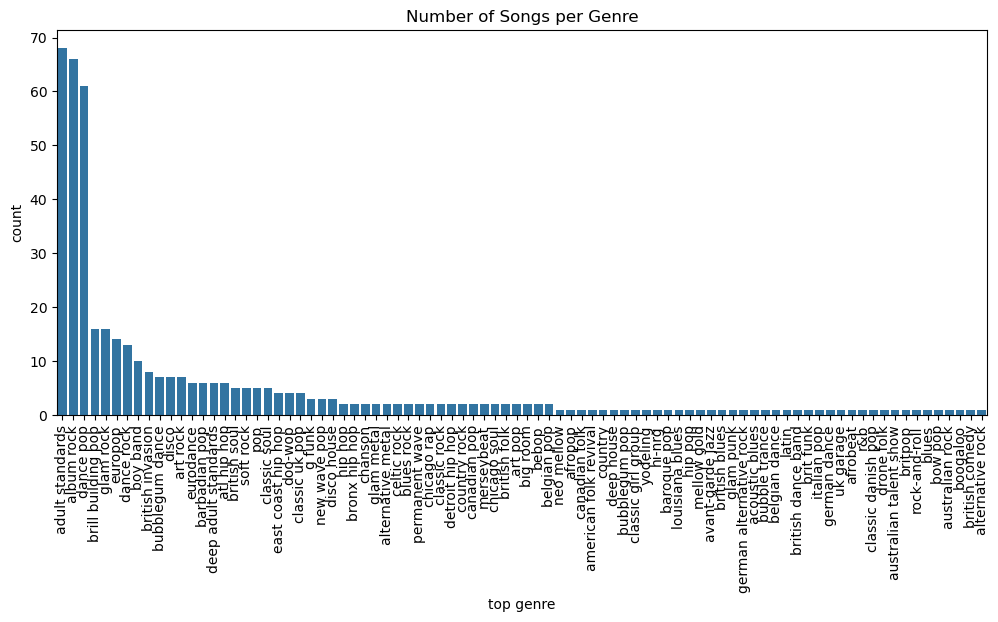

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Genre distribution plot
plt.figure(figsize=(12,5))
sns.countplot(x=y, order=y.value_counts().index)
plt.xticks(rotation=90)
plt.title("Number of Songs per Genre")
plt.show()


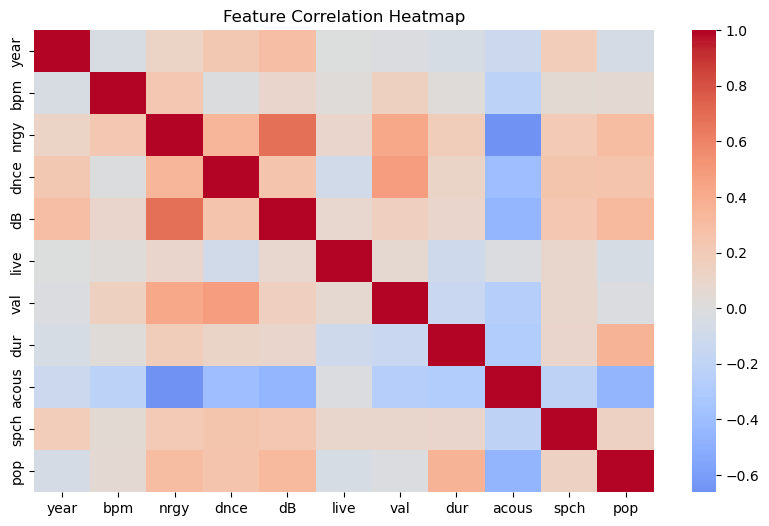

In [63]:
# Correlation heatmap of features
plt.figure(figsize=(10,6))
sns.heatmap(X.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


### Observations
- The **genre distribution** shows which classes have more songs and which are rare.  
- The **correlation heatmap** highlights relationships between features (e.g., tempo and bpm may be strongly correlated).  
- These insights help us understand potential biases and dependencies in the dataset.  


## 🤖 Model Training

For the model, I used **LightGBM** since it is fast and usually performs well on classification problems.  
To keep things simple, I just split the dataset into training and validation sets (80/20).  
This helps me quickly check how well the model is doing before making the final predictions.


In [72]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# simple 80/20 split (no stratify, avoids errors)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# basic LightGBM model
model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(encoder.classes_),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

# train the model
model.fit(X_train, y_train)

# predict on validation
val_preds = model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print("Validation Accuracy:", val_acc)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 362, number of used features: 11
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -1.979621
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -1.866293
[LightGBM] [Info] Start training from score -5.198497
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -5.198497
[LightGBM] [Info] Start training from score -4.282206
[LightGBM] [Info] Start training from score -4.793032
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [Info] Start training from score -5.891644
[LightGBM] [

### Observations
- After a simple 80/20 split, the model gave me a validation accuracy score.  
- It’s not perfect, but it shows the model is learning.  
- Some rare genres are probably harder for the model to predict correctly.  
- I kept the setup simple without tuning, since this is just a first attempt.  


In [75]:
# Train on the full training dataset
final_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=len(encoder.classes_),
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)
final_model.fit(X, y_encoded)

# Predict genres for test set
test_preds = final_model.predict(X_test)
test_preds_labels = encoder.inverse_transform(test_preds)

# Create submission file
submission = pd.DataFrame({
    "Id": test_data["Id"],
    "top genre": test_preds_labels
})

submission.to_csv("spotify_submission.csv", index=False)
print("✅ Submission file saved as spotify_submission.csv")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 685
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 11
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -1.896384
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -1.926237
[LightGBM] [Info] Start training from score -5.422745
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -5.422745
[LightGBM] [Info] Start training from score -4.169982
[LightGBM] [Info] Start training from score -4.324133
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [Info] Start training from score -6.115892
[LightGBM] [

### Observations
- I trained the final model on all of the training data to use as much information as possible.  
- The predictions were generated for the test dataset and saved in the required CSV format.  
- The file `spotify_submission.csv` is now ready for submission.  
